In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import viz

from matplotlib.ticker import FuncFormatter
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import linregress

colors = viz.plotting_style()
lin_colors = list(colors.values())
greys = sns.color_palette('Greys', 6)

plt.style.use('style.mpl')

# Code generating Figure 1 
Figure 1 describes "stylized facts" about microbial metabolism and growth that motivate the integration of redox and resource allocation models. 

Also generates any supplementary figures that are plausibly attached to Figure 1.

In [2]:
# Load E. coli growth rates from Schmidt et al. 2016 -- this is in the
# proteome data since Schmidt et al. is primarily a proteomics paper.
coli_data = pd.read_csv('../data/proteomes/Coli/Chure_proteome_NOSC.csv')
mask = np.logical_and(
    coli_data.dataset.str.contains('schmidt'),
    coli_data.growth_mode != 'chemostat') 

# Remove stress conditions
stress_conds = 'pH6,osmotic_stress_glucose,42C'.split(',')
mask = np.logical_and(mask, ~coli_data.condition.isin(stress_conds))
coli_csource_df = coli_data[mask].sort_values('growth_rate_hr')
coli_csource_df.condition.replace({'glycerol_pAA': 'glycerol + AA', 'lb_miller': 'rich (LB)'}, inplace=True)

In [3]:
# Empirically observed metabolic modes for E. coli. 
# These are pairs of (C course, e- acceptor) that are observed to support growth.
# This list was manually curated from various literature sources.
coli_modes_df = pd.read_excel('../data/physiology/coli_metabolic_modes.xlsx', index_col=0)

# Load inferred biomass C and ZC from Bremer & Dennis 2008
# This file is generated by the script munge/munge_biomass_composition.py
biomass_ZC_df = pd.read_csv('../data/physiology/BremerDennis2008_InferredZCB.csv', index_col=0)

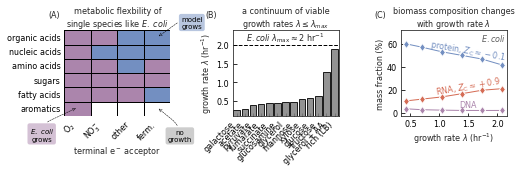

In [4]:
# Make figure 1
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(7.24, 2.5))
        
# Panel on range of metabolic modes. 
plt.sca(axs[0])
coli_modes_num = coli_modes_df.replace(
    {'experiment': 3, 'engineered': 2, 'model': 1, np.NAN: 0})
cmap = ['w'] + [colors[x] for x in 'blue,green,purple'.split(',')]
sns.heatmap(coli_modes_num, cmap=cmap, cbar=False, linewidths=0.5, linecolor='black')
plt.ylabel('')
plt.xlabel('')
tick_labels = {
    'CO2': 'CO$_2$',
    'O2': 'O$_2$', 
    'NO3': 'NO$_3^{-}$',
    'DMSO/TMAO': 'other',
    'fermentation': 'ferm.'}
my_ticks = [tick_labels[x] for x in coli_modes_num.columns]
plt.xticks(np.arange(len(my_ticks))+0.5, my_ticks, rotation=45, ha='right')
plt.tick_params(axis=u'both', which=u'both', length=0)
plt.xlabel('terminal e$^-$ acceptor')

# annotate the growth/non-growth with plt.annotate using same coordinates and positions as figtext
arrowprops = dict(
    arrowstyle="->",
    connectionstyle="arc,angleA=90,armA=10,rad=10",
    linestyle='--',
    facecolor='black', edgecolor='black', lw=0.5)
bbox = dict(boxstyle="round", fc=colors['purple'], ec="w", lw=0, alpha=0.5)
plt.annotate('$E.$ $coli$\ngrows', xy=(0.5, 5.4), xytext=(0.08, 0.17), textcoords='figure fraction',
             fontsize=7, ha='center', color='k', annotation_clip=True, arrowprops=arrowprops, bbox=bbox)
bbox = dict(boxstyle="round", fc=colors['blue'], ec="w", lw=0, alpha=0.5)
plt.annotate('model\ngrows', xy=(3.5, 0.5), xytext=(0.368, 0.8), textcoords='figure fraction',
             fontsize=7, ha='center', color='k', annotation_clip=True, arrowprops=arrowprops, bbox=bbox)
bbox = dict(boxstyle="round", fc=greys[-2], ec="w", lw=0, alpha=0.3)
plt.annotate('no\ngrowth', xy=(3.5, 5.4), xytext=(0.345, 0.17), textcoords='figure fraction',
             fontsize=7, ha='center', color='k', annotation_clip=True, arrowprops=arrowprops, bbox=bbox)

# Panel on maximum growth rate -- E. coli growth rates by C-source from Schmidt 2016.
plt.sca(axs[1])
sns.barplot(data=coli_csource_df, y='growth_rate_hr', x='condition', color='grey',
            alpha=0.85, edgecolor='k', lw=1)
plt.axhline(2.0, color='k', ls='--', lw=1)
plt.xticks(rotation=45, ha='right')# , fontsize=6)
plt.ylim(0.1, 2.4)
plt.text(6, 2.03, '$E. coli$ $\lambda_{\mathrm{max}} \\approx 2$ hr$^{-1}$', va='bottom', ha='center', fontsize=8)

plt.ylabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.xlabel('')

plt.sca(axs[2])
labels = 'protein,RNA,DNA'.split(',')
keys = ['{0}_mass_fraction'.format(l) for l in labels]

# Plot the fractional composition of biomass.
pal = [colors[cid] for cid in "blue,red,purple".split(",")]
for l,k,c in zip(labels, keys, pal):  
    ys = biomass_ZC_df[k]*100
    plt.plot(biomass_ZC_df.growth_rate_hr, ys, marker='d', label=l,
             markersize=6, markeredgecolor='w', lw=1, color=c)

labels = ["protein, $Z_{\mathrm{C}} \\approx -0.1$", 
          "RNA, $Z_{\mathrm{C}} \\approx +0.9$",
          "DNA"]
lcolors = ['blue', 'red', 'purple']
locs = [(1.5, 54, -10), (1.5, 23, 10), (1.5, 7, 0)]
for label, c, loc in zip(labels, lcolors, locs):
    x,y,rotation = loc
    plt.text(x, y, label, ha='center', va='center', color=colors[c],
             transform=plt.gca().transData, rotation=rotation, fontsize=8)

plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel('mass fraction (%)')
plt.tick_params(axis='both')
plt.legend(loc=1).set_visible(False)
plt.ylim(-3, 72)
plt.text(0.99, 0.98, '$E. coli$', transform=plt.gca().transAxes,
         ha='right', va='top', color=greys[-2], fontsize=8)


titles = ["metabolic flexbility of\nsingle species like $E.$ $coli$",
          "a continuum of viable\ngrowth rates $\lambda \leq \lambda_{max}$",
          "biomass composition changes\nwith growth rate $\lambda$"]
for ax, title in zip(axs, titles):
    ax.set_title(title)

label_pos = [(0.1, 0.88), (0.40, 0.88), (0.725, 0.88)]
for (x,y), label in zip(label_pos, 'ABC'):
    plt.figtext(x, y, '({0})'.format(label), fontsize=8)

plt.tight_layout()
plt.savefig('../output/Fig1.pdf', facecolor='white', dpi=300)
plt.show()

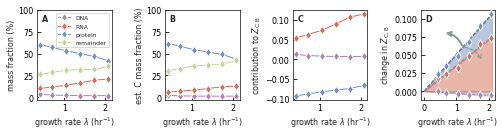

In [5]:
# Generate an SI figure explaining how we calcualte the change in ZCB with growth rate.
# This is not trivial since there are unmeasured compartments with unknown mixes of 
# molecules (e.g. lipids, carbohydrates, etc.) and therefore unknown ZC values.
mosaic = "ABCD" 
fig, axs = plt.subplot_mosaic(mosaic, figsize=(7.08, 2))

plt.sca(axs['A'])
labels = 'DNA,RNA,protein,remainder'.split(',')
legend_labels = ["DNA",
                 "RNA, $Z_{\mathrm{C}} \\approx +0.9$",
                 "protein, $Z_{\mathrm{C}} \\approx -0.1$", 
                 "remainder"]
keys = ['{0}_mass_fraction'.format(l) for l in labels]
pal = [colors[cid] for cid in "purple,red,blue,light_green".split(",")]
for l,k,c in zip(labels, keys, pal):  
    ys = biomass_ZC_df[k]*100
    plt.plot(biomass_ZC_df.growth_rate_hr, ys, marker='d', label=l,
             markersize=6, markeredgecolor='w', lw=1, color=c)

plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel('mass fraction (%)')
plt.ylim(-3, 100)
plt.legend(loc=1, framealpha=0.7, fontsize=6)

plt.sca(axs['B'])
keys = ['{0}_C_mass_fraction'.format(l) for l in labels]

# Plot the fractional composition of biomass.
for l,k,c in zip(labels, keys, pal):  
    ys = biomass_ZC_df[k]*100
    plt.plot(biomass_ZC_df.growth_rate_hr, ys, marker='d', label=l,
             markersize=6, markeredgecolor='w', lw=1, color=c)

plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel('est. C mass fraction (%)')
plt.tick_params(axis='both')
plt.ylim(-3, 100)

plt.sca(axs['C'])
ZCs = [0.6, 0.9, -0.15,  0.0 ]
ZC_contributions = biomass_ZC_df[keys]*np.array(ZCs)
ZC_est = ZC_contributions.sum(axis=1)

for l,k,c in zip(labels, keys, pal):
    if l == 'remainder':
        continue
    ys = ZC_contributions[k]
    plt.plot(biomass_ZC_df.growth_rate_hr, ys, marker='d', label=l,
             markersize=6, markeredgecolor='w', lw=1, color=c)

plt.ylabel('contribution to $Z_{\mathrm{C,B}}$')
plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')

plt.sca(axs['D'])
reg = linregress(biomass_ZC_df.growth_rate_hr, ZC_est)
ZCB_slope, ZCB_intercept = reg.slope, reg.intercept
lam_vals = np.arange(0, biomass_ZC_df.growth_rate_hr.max()+0.1, 0.1)
pred_dZCB = ZCB_slope*lam_vals

plt.scatter(biomass_ZC_df.growth_rate_hr, ZC_est - ZCB_intercept, marker='d',
            label='total $Z_{\mathrm{C}}$',
            s=40, edgecolor='w',
            color='k')
plt.plot(lam_vals, pred_dZCB, ls='--', lw=1, color='k', label='linear fit')

bottom = np.zeros_like(lam_vals)
bottom_pts = np.zeros_like(biomass_ZC_df.growth_rate_hr.values)
for l,k,c in zip(labels, keys, pal):
    if l == 'remainder':
        continue
    ys = ZC_contributions[k]
    cat_reg = linregress(biomass_ZC_df.growth_rate_hr, ys)
    my_slope, my_int = cat_reg.slope, cat_reg.intercept
    ys_sum = bottom_pts + ys - my_int
    pred_dZCB_cat = my_slope*lam_vals
    pred_dZCB_cat_sum = bottom + pred_dZCB_cat
    plot_bottom = bottom
    if (bottom < 0).any():
        plot_bottom = np.zeros_like(lam_vals)
    plt.scatter(biomass_ZC_df.growth_rate_hr, ys_sum, marker='d',
                label=l, s=40, edgecolor='w', color=c, zorder=10)
    plt.fill_between(lam_vals, plot_bottom, pred_dZCB_cat_sum, color=c, alpha=0.5)
    plt.plot(lam_vals, pred_dZCB_cat_sum, ls='--', lw=1, color=c, label=l)
    bottom = pred_dZCB_cat_sum
    bottom_pts = ys_sum

# draw arrows around the sum of the contributions
idx = -10
from_pt = lam_vals[idx], pred_dZCB[idx]
to_pt1 = lam_vals[idx]-0.6, pred_dZCB[idx]+0.02
to_pt2 = lam_vals[idx]+0.6, pred_dZCB[idx]-0.02
arrowprops = dict(
    arrowstyle="->",
    connectionstyle="arc3,rad=0.3",
    linestyle='-',
    facecolor=colors['dark_green'], edgecolor=colors['dark_green'],
    lw=2)
plt.annotate('', xy=to_pt1, xytext=from_pt,
             arrowprops=arrowprops, zorder=10)
arrowprops.update(connectionstyle="arc3,rad=-0.3", ls='--', lw=1)
plt.annotate('', xy=to_pt2, xytext=from_pt,
             arrowprops=arrowprops, zorder=10)

plt.ylabel('change in $Z_{\mathrm{C,B}}$')
plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')

for panel_label in 'ABCD':
    plt.sca(axs[panel_label])
    plt.text(0.06, 0.88, panel_label, transform=plt.gca().transAxes,
             fontsize=8, weight='bold')
        
plt.tight_layout()
plt.savefig('../output/FigSX_delta_ZCB_calc.png', facecolor='white', dpi=300)
plt.show()


In [6]:
# munge/munge_coli_FBA.py calculates the growth rate matrix for E. coli
# this is the growth on pairs of (C source, e- acceptor).
growth_mat_df = pd.read_csv('../output/iML1515_growth_rate_matrix.csv', index_col=[0,1])
binary_growth_mat_df = pd.read_csv('../output/iML1515_binary_growth_matrix.csv', index_col=[0,1])

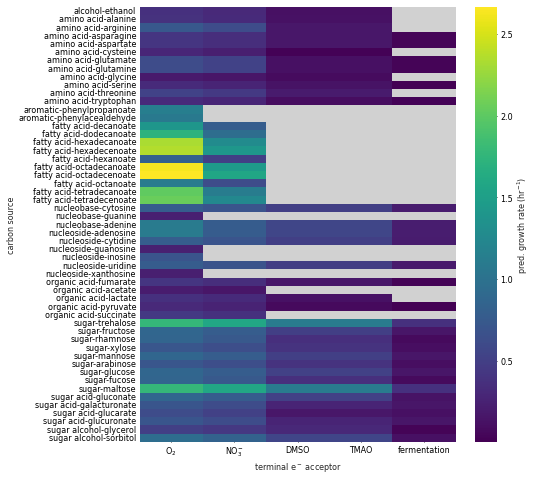

In [7]:
# Supplementary figure showing the 2D growth matrix
# the of iML1515 model of E. coli.
cols = 'O2,NO3,DMSO,TMAO,fermentation'.split(',')
cmap = sns.color_palette('cividis', as_cmap=True)
cmap.set_bad('white')

plt.figure(figsize=(7.08, 8))
nice_labels = dict(O2='O$_2$', NO3='NO$_3^{-}$', DMSO='DMSO', TMAO='TMAO', fermentation='fermentation')
xticklabels = [nice_labels.get(x, x) for x in cols]
growth_mat_df[growth_mat_df == 0] = np.nan
my_cmap = sns.color_palette('viridis', as_cmap=True)
my_cmap.set_bad(greys[1])
sns.heatmap(growth_mat_df[cols], cbar=True, fmt='', 
            cbar_kws=dict(label='pred. growth rate (hr$^{-1}$)'),
            xticklabels=xticklabels, cmap=my_cmap)
plt.xlabel('terminal e$^-$ acceptor')
plt.ylabel('carbon source')

plt.savefig('../output/FigSX_iML1515_growth_matrix.png', dpi=300, bbox_inches='tight', facecolor='white')